In [91]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import subprocess
import sys

def install_package(package_name):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
    except subprocess.CalledProcessError:
        print(f"Error installing {package_name}")
        
# Check and install packages
try:
    import catboost
except ImportError:
    print("CatBoost not found, installing...")
    install_package('catboost')

try:
    import xgboost
except ImportError:
    print("XGBoost not found, installing...")
    install_package('xgboost')

try:
    import lightgbm
except ImportError:
    print("LightGBM not found, installing...")
    install_package('lightgbm')

try:
    import optuna
except ImportError:
    print("Optuna not found, installing...")
    install_package('optuna')


In [92]:
train=pd.read_csv("train.csv")
test=pd.read_csv('test.csv')
x=train.drop(['rainfall','id'],axis=1).copy()
y=train['rainfall']

In [93]:
def describe(df):
  desc=pd.DataFrame()
  desc['dtype']=df.dtypes
  desc['null']=df.isnull().sum()
  desc['%null'] = desc['null'] / len(df) * 100
  # desc['mean']=df.mean()
  # desc['median']=df.median()
  #desc['%unique'] = desc['nunique'] /len(df)*100
  desc = pd.concat([desc,df.describe(include = 'all').T],axis=1).sort_values(by='null',ascending=False)
  desc['count']=df.count()
  desc['unique']=df.nunique()
  # desc['freq/mean']=desc['freq'].fillna(desc['mean']).drop(['freq','mean'],axis=1)
  display(desc)
# describe(train)

In [94]:
xtr=x[:1752]
xte=x[1752:]
ytr=y[:1752]
yte=y[1752:]
# # @title gaussian
# from sklearn.ensemble import HistGradientBoostingClassifier
# model=HistGradientBoostingClassifier()

# model.fit(xtr,ytr)
# model.score(xte,yte)


In [95]:
xte.shape

(438, 11)

In [96]:
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score,recall_score

In [ ]:
# @title xgboost
from sklearn.metrics import mean_squared_error
import optuna

def create(trial):
  params = {
          "min_child_weight":trial.suggest_int('min_child_weight',1,5),
          "max_depth": trial.suggest_int("max_depth", 5, 10),
          "gamma":trial.suggest_float('gamma',0,0.5),
          "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
          "subsample": trial.suggest_float("subsample", 0.5, 1.0),
          "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
          #"reg_alpha":trial.suggest_float('reg_alpha',0 ,5),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
          "max_bin" :trial.suggest_int('max_bin',500,8000),
          "scale_pos_weight":trial.suggest_float('scale_pos_weight',7.0,16.0,),


      }

  return params

model=xgb.XGBClassifier(
#      learning_rate =0.1, max_depth=4,
#  min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=0,
#  tree_method="hist"
eval_metric="aucpr")

def objective(trial):


    model = xgb.XGBClassifier(**create(trial))
    model.fit(xtr, ytr)
    predictions = model.predict(xte)
    # acc = f1_score(yte, predictions)
    rmse = -mean_squared_error(yte, predictions)

    #cross = cross_val_score(model,x,y,cv=3, n_jobs=-1).mean()
    return rmse

optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

from IPython.display import clear_output

clear_output(wait=True)


best_params_xgb=study.best_params
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: -0.10009238123893738
  Params: 
    min_child_weight: 5
    max_depth: 9
    gamma: 0.05175703833170145
    learning_rate: 0.06520239516167828
    subsample: 0.8821151327217127
    colsample_bytree: 0.8310470198146271
    lambda: 0.6310364622735297
    alpha: 0.5178839057881099
    max_bin: 4675
    scale_pos_weight: 7.384714078338558


In [ ]:
# @title LightGBM
# from sklearn.metrics import mean_squared_error
import optuna
import warnings
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed")

def create(trial):

  params = {
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "random_state": 42,
    }
  return params

model=lgb.LGBMClassifier(# "num_class": 3,  # Set the number of classes
    objective='binary',metric='auc_mu')

def objective(trial):


    model = lgb.LGBMClassifier(**create(trial))
    model.fit(xtr, ytr)
    predictions = model.predict(xte)
    acc = f1_score(yte, predictions)
    # rmse = -mean_squared_error(yte, predictions)

    #cross = cross_val_score(model,x,y,cv=3, n_jobs=-1).mean()
    return acc

optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

from IPython.display import clear_output

clear_output(wait=True)

best_params_lgb=study.best_params
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
# @title catboost
from catboost import CatBoostClassifier, Pool, cv, MetricVisualizer
from sklearn.metrics import mean_squared_error
import optuna
def create(trial):

  params = {

        "random_state": 42,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 400, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.9),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "scale_pos_weight":trial.suggest_float('scale_pos_weight',7.0,16.0,)
    }
  return params


model=CatBoostClassifier(eval_metric='F1',verbose=100)

def objective(trial):


    model = CatBoostClassifier(**create(trial))
    model.fit(xtr, ytr)
    predictions = model.predict(xte)
    acc = f1_score(yte, predictions)
    # rmse = -mean_squared_error(yte, predictions)

    #cross = cross_val_score(model,x,y,cv=3, n_jobs=-1).mean()
    return acc

optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

from IPython.display import clear_output

clear_output(wait=True)

best_params_cat=study.best_params
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(**best_params_xgb,eval_metric='aucpr', random_state=42),
    'CatBoost': CatBoostClassifier(**best_params_cat,eval_metric='F1', verbose=100,random_state=42),
    'LightGBM': lgb.LGBMClassifier(**best_params_lgb,random_state=42,objective='binary'),

}

In [ ]:
for name, model in models.items():
    print(f'\nTraining {name}...')
    model.fit(xtr, ytr)
    y_pred = model.predict(X_valid)


    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred)
    recall=recall_score(y_valid,y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')
    print('Classification Report:\n', classification_report(y_valid, y_pred))
    print('Confusion Matrix:\n', confusion_matrix(y_valid, y_pred))



In [ ]:
model=xgb.XGBRegressor(**best_params_xgb,eval_metric='aucpr', random_state=42)
model.fit(xtr,ytr)
model.score(xte,yte)

0.3650997281074524

<Axes: >

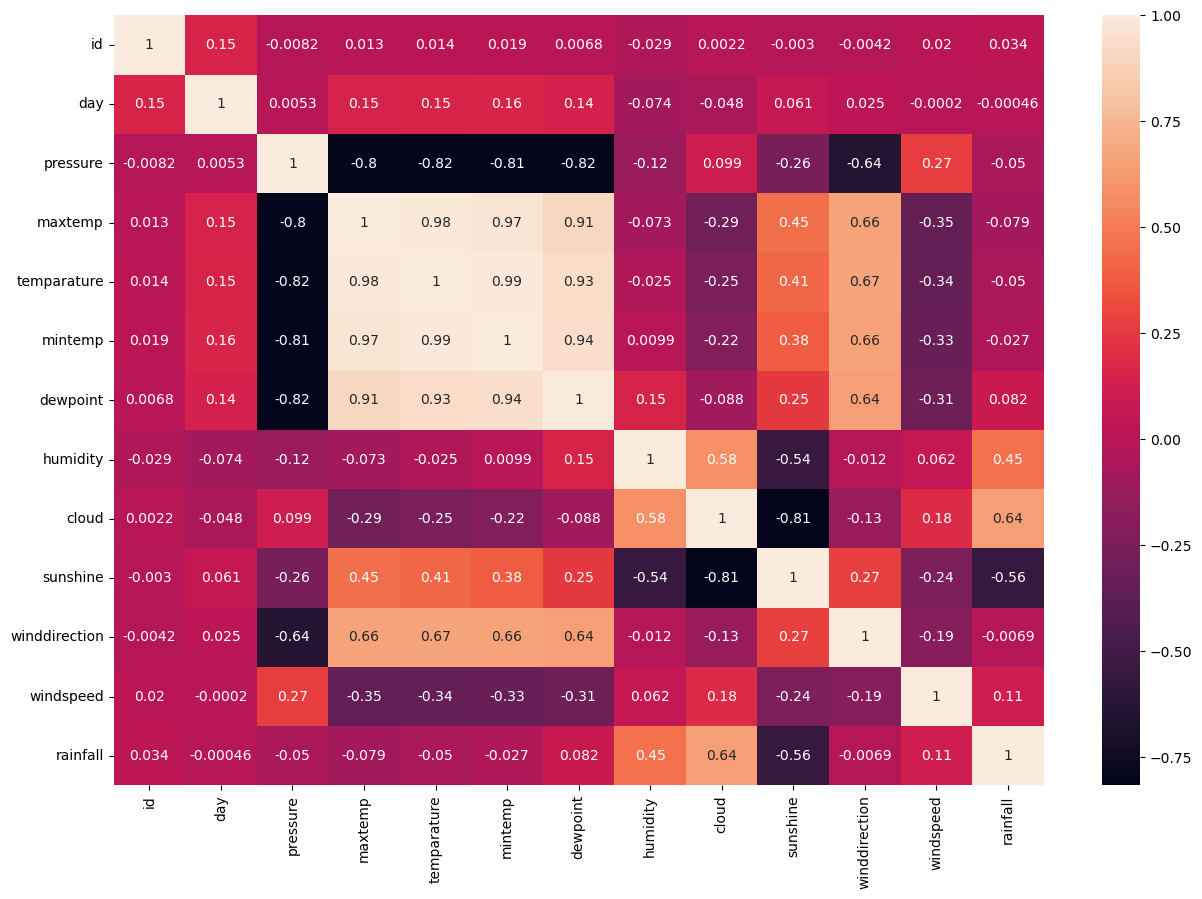

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(),annot=True)

In [ ]:

l=model.predict(test.drop('id',axis=1))
df=pd.DataFrame()
df['rainfall']=l
df['id']=test['id']
df.to_csv("sample_submission.csv", index=False)